In [9]:
import random
import copy
from src.frenchdeck import FrenchDeck
%matplotlib inline

cards = FrenchDeck()
cards.shuffle()
hand = cards.deal(2)
hand

[Card(rank='2', suit='hearts'), Card(rank='6', suit='hearts')]

In [2]:
rank_translation = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'J': 10, 'Q':10, 'K':10, 'A':10}
hand_rank_values = [rank_translation.get(card.rank) for card in hand]
score = sum(hand_rank_values)
print('score = ' + str(score))
upper_lim = 21 - score
print('upper_lim = ' + str(upper_lim))

score = 12
upper_lim = 9


## Probability of going bust if twisting

In [3]:
if upper_lim < 2: # Zero chance of getting less than 21
    print('stick')
if upper_lim >= 10: # Zero chance of getting more than 21
    print('twist')

In [36]:
samples = []
for n in range(1000):
    simulation_cards = copy.deepcopy(cards)
    simulation_cards.shuffle()
    new_card = simulation_cards.deal()
    rank = rank_translation.get(new_card[0].rank)
    failure = [rank > upper_lim]
    samples += failure

In [37]:
sum(samples)/1000

0.39

In [6]:
# Import libraries
import pystan # install with pip install pystan
import pandas as pd
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

# The Stan model as a string.
model_code = """
# Here we define the data we are going to pass into the model
data {
  int n; # Number of trials
  int s;  # Number of successes
}

# Here we define what 'unknowns' aka parameters we have.
parameters {
  real<lower=0, upper=1> rate;
}

# The generative model
model {
  rate ~ uniform(0, 1);
  s ~ binomial(n, rate);
}

"""
# Compiling and producing posterior samples from the model.
model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ac92955a9845115f07572bfa931a265b NOW.


Inference for Stan model: anon_model_ac92955a9845115f07572bfa931a265b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rate   0.39  4.2e-4   0.02   0.36   0.38   0.39    0.4   0.42   1333    1.0
lp__ -670.6    0.02   0.68 -672.6 -670.8 -670.4 -670.2 -670.1   1792    1.0

Samples were drawn using NUTS at Sat May 29 10:03:49 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Figure(432x288)
1.0


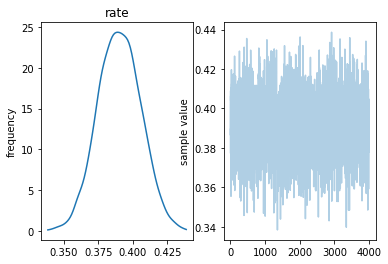

In [38]:
model_data = dict(n = len(samples), s = sum(samples))
fit = model.sampling(data=model_data)

# Plotting and summarizing the posterior distribution
print(fit)
print(fit.plot())

# Export the samples to a data.frame for easier handling.
posterior = pd.DataFrame(fit.extract())

# Now we could, for example, calculate the probability that the rate is higher
# than, say, 20%
print(sum(posterior.rate > 0.2) / len(posterior.rate))

## Probability the other player will win given that we stick

In [ ]:
# What is the other player likely to have?

In [39]:
samples = []
for n in range(1000):
    simulation_cards = copy.deepcopy(cards)
    simulation_cards.shuffle()
    opponents_cards = simulation_cards.deal(2)
    opponents_hand_rank_values = [rank_translation.get(card.rank) for card in opponents_cards]
    opponents_score = sum(opponents_hand_rank_values)
    failure = [opponents_score > score]
    samples += failure

Inference for Stan model: anon_model_ac92955a9845115f07572bfa931a265b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rate   0.73  3.9e-4   0.01    0.7   0.72   0.73   0.74   0.76   1246    1.0
lp__ -585.3    0.01   0.65 -587.1 -585.5 -585.1 -584.9 -584.8   2068    1.0

Samples were drawn using NUTS at Sat May 29 10:03:58 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Figure(432x288)
1.0


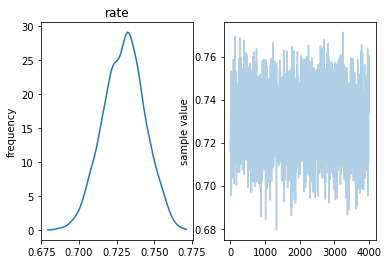

In [40]:
model_data = dict(n = len(samples), s = sum(samples))
fit = model.sampling(data=model_data)

# Plotting and summarizing the posterior distribution
print(fit)
print(fit.plot())

# Export the samples to a data.frame for easier handling.
posterior = pd.DataFrame(fit.extract())

# Now we could, for example, calculate the probability that the rate is higher
# than, say, 20%
print(sum(posterior.rate > 0.2) / len(posterior.rate))

## Decision - Twist or stick?

In [ ]:
# P(opponent has higher card values if we stick) - P(going bust if we twist) > 0

In [46]:
# Import libraries
import pystan # install with pip install pystan
import pandas as pd
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

# The Stan model as a string.
model_code = """
data {
  # Number of trials
  int nA;
  int nB;
  # Number of successes
  int sA;
  int sB;
}

parameters {
  real<lower=0, upper=1> rateA;
  real<lower=0, upper=1> rateB;
}

model {
  rateA ~ uniform(0, 1);
  rateB ~ uniform(0, 1);
  sA ~ binomial(nA, rateA);
  sB ~ binomial(nB, rateB); 
}

generated quantities {
  real rate_diff;
  rate_diff <- rateB - rateA;
}
"""
# Compiling and producing posterior samples from the model.
decision_model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_528490c7c02220dbc5a4da271dc455d4 NOW.


In [47]:
samples_opponent = []
samples_draw = []

for n in range(1000):
    opponents_cards = simulation_cards.deal(2)
    opponents_hand_rank_values = [rank_translation.get(card.rank) for card in opponents_cards]
    opponents_score = sum(opponents_hand_rank_values)
    failure = [opponents_score > score]
    samples_opponent += failure

    simulation_cards = copy.deepcopy(cards)
    simulation_cards.shuffle()
    new_card = simulation_cards.deal()
    rank = rank_translation.get(new_card[0].rank)
    failure = [rank > upper_lim]
    samples_draw += failure

Inference for Stan model: anon_model_528490c7c02220dbc5a4da271dc455d4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rateA       0.37  2.5e-4   0.02   0.34   0.36   0.37   0.38    0.4   3721    1.0
rateB       0.72  2.6e-4   0.01   0.69   0.71   0.72   0.73   0.75   3042    1.0
rate_diff   0.36  3.6e-4   0.02   0.32   0.34   0.36   0.37    0.4   3421    1.0
lp__       -1250    0.02   1.01  -1253  -1251  -1250  -1250  -1249   1755    1.0

Samples were drawn using NUTS at Sat May 29 10:23:43 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Figure(432x288)


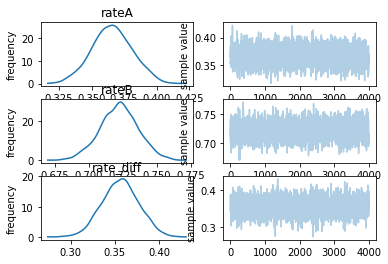

In [51]:
model_data = dict(nA = len(samples_draw), sA = sum(samples_draw), nB = len(samples_opponent), sB = sum(samples_opponent))
fit = decision_model.sampling(data=model_data)

# Plotting and summarizing the posterior distribution
print(fit)
print(fit.plot())

In [52]:
# Export the samples to a data.frame for easier handling.
posterior = pd.DataFrame(fit.extract())
np.mean(posterior.rate_diff > 0) # same as sum(posterior.rate_diff > 0) / len(posterior.rate_diff)

1.0

<AxesSubplot:>

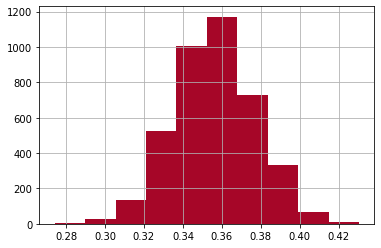

In [55]:
posterior['rate_diff'].hist(color="#A60628")